# Modelo de predição de valor da bolsa do BTG Pactual
---
Instruções:
"Seu desafio é criar um modelo preditivo de redes neurais Long Short Term Memory (LSTM) para predizer o valor de fechamento da bolsa de valores de uma empresa à sua escolha e realizar toda a pipeline de desenvolvimento, desde a criação do modelo preditivo até o deploy do modelo em uma API que permita a previsão de preços de ações."

## Importação das bibliotecas necessárias

In [2]:

import yfinance as yf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt

import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

import mlflow
import mlflow.keras

In [3]:
import os

## Carregamento e limpeza dos dados

In [4]:
# Símbolo do BTG Pactual listado na B3 (unidades): BPAC11.SA
symbol = 'BPAC11.SA'
start_date = '2015-01-01'
end_date = '2025-07-01'

df = yf.download(symbol, start=start_date, end=end_date)

C:\Users\maria\AppData\Local\Temp\ipykernel_12200\1229583237.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [5]:
# Verificando o DF

df.head()

Price,Close,High,Low,Open,Volume
Ticker,BPAC11.SA,BPAC11.SA,BPAC11.SA,BPAC11.SA,BPAC11.SA
Date,,,,,
2017-02-24,3.469847,3.469847,3.469847,3.469847,5200
2017-03-01,3.422184,3.469847,3.422184,3.469847,17200
2017-03-02,3.422184,3.422184,3.422184,3.422184,0
2017-03-03,3.574703,3.622366,3.527041,3.622366,7200
2017-03-06,3.660498,3.717694,3.527043,3.584238,22800


In [6]:
# Shape do DF

df.shape

(2076, 5)

In [7]:
# Verificando nomes das colunas 

df.columns

MultiIndex([( 'Close', 'BPAC11.SA'),
            (  'High', 'BPAC11.SA'),
            (   'Low', 'BPAC11.SA'),
            (  'Open', 'BPAC11.SA'),
            ('Volume', 'BPAC11.SA')],
           names=['Price', 'Ticker'])

In [8]:
# Formatando o nome das colunas do df

i = 0
columns = []

for column in df.columns:
    column_name = df.columns[i][0]
    i += 1
    columns.append(column_name)
    # print(column_name)

print(columns)

['Close', 'High', 'Low', 'Open', 'Volume']


In [9]:
# Renomeando colunas para as que estão contidas em columns 

df.columns = columns

df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2017-02-24,3.469847,3.469847,3.469847,3.469847,5200
2017-03-01,3.422184,3.469847,3.422184,3.469847,17200
2017-03-02,3.422184,3.422184,3.422184,3.422184,0
2017-03-03,3.574703,3.622366,3.527041,3.622366,7200
2017-03-06,3.660498,3.717694,3.527043,3.584238,22800


In [10]:
# Transformando o Index (data) em uma coluna de data

df.reset_index(inplace=True)

df.head()

,Date,Close,High,Low,Open,Volume
0,2017-02-24,3.469847,3.469847,3.469847,3.469847,5200
1,2017-03-01,3.422184,3.469847,3.422184,3.469847,17200
2,2017-03-02,3.422184,3.422184,3.422184,3.422184,0
3,2017-03-03,3.574703,3.622366,3.527041,3.622366,7200
4,2017-03-06,3.660498,3.717694,3.527043,3.584238,22800


In [11]:
# Selecionando apenas as colunas que importam 

df = df[['Date', 'Close']]

df.head()

,Date,Close
0,2017-02-24,3.469847
1,2017-03-01,3.422184
2,2017-03-02,3.422184
3,2017-03-03,3.574703
4,2017-03-06,3.660498


In [12]:
# Verificando o tipo de dados das colunas:

print(df.dtypes)

Date     datetime64[ns]
Close           float64
dtype: object


In [13]:
# Procurando por valores nulos

df.isnull().sum()

Date     0
Close    0
dtype: int64

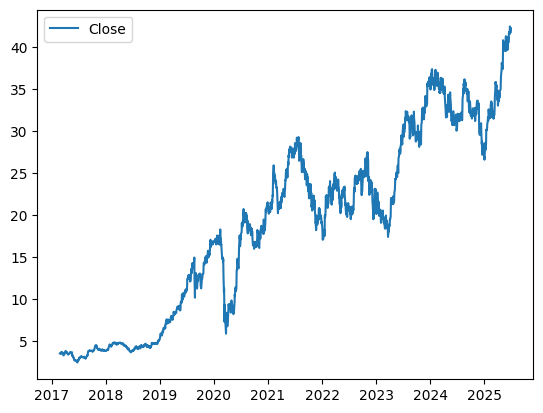

In [14]:
# Plotando para verificar o comportamento e sua relação com a data 

plt.plot(df['Date'], df['Close'], label='Close')
plt.legend()
plt.show()

## Pré processamento dos dados

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [16]:
df_processado = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [17]:
# Queremos prever ações nos últimos 60 dias, então...
previsao_em_dias = 60

In [18]:
# Função que cria as sequências 

def cria_sequencias(dado, previsao_em_dias):
  x, y = [], []

  for i in range(previsao_em_dias, len(df_processado)):
      x.append(df_processado[i-previsao_em_dias:i, 0])
      y.append(df_processado[i, 0])

  return np.array(x), np.array(y)

x, y = cria_sequencias(df_processado, previsao_em_dias)
x = x.reshape((x.shape[0], x.shape[1], 1))

In [19]:
print(x.shape)

(2016, 60, 1)


## Separando dados em treino e teste

In [20]:
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Modelo

In [21]:
# Definindo o caminho para o salvamento do modelo
model_path = os.path.join("models_saved", "modelo_lstm.h5")
os.makedirs("models_saved", exist_ok=True)

c:\Users\maria\OneDrive\Documentos\FIAP\entrega_4\.env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0175 - val_loss: 7.3520e-04
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 4.9811e-04 - val_loss: 7.4095e-04
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.8437e-04 - val_loss: 6.7952e-04
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.7407e-04 - val_loss: 7.7381e-04
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 3.5957e-04 - val_loss: 6.2206e-04
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.5925e-04 - val_loss: 6.4992e-04
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.5850e-04 - val_loss: 5.7843e-04
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 3.6528e-04 - val_loss: 6.4880e-04
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 3.1907e-04 - val_loss: 5.5830e-04
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 2.8293e-04 - val_loss: 8.5507e-04
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.

2025/07/06 21:30:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Modelo salvo com sucesso!
Preço médio real: 33.88
Erro percentual médio aproximado: 2.33%
🏃 View run Treinamento_LSTM at: http://localhost:5000/#/experiments/478480733693104801/runs/44f9b8024c0c4cb787c84f8e9eb1d0f6
🧪 View experiment at: http://localhost:5000/#/experiments/478480733693104801


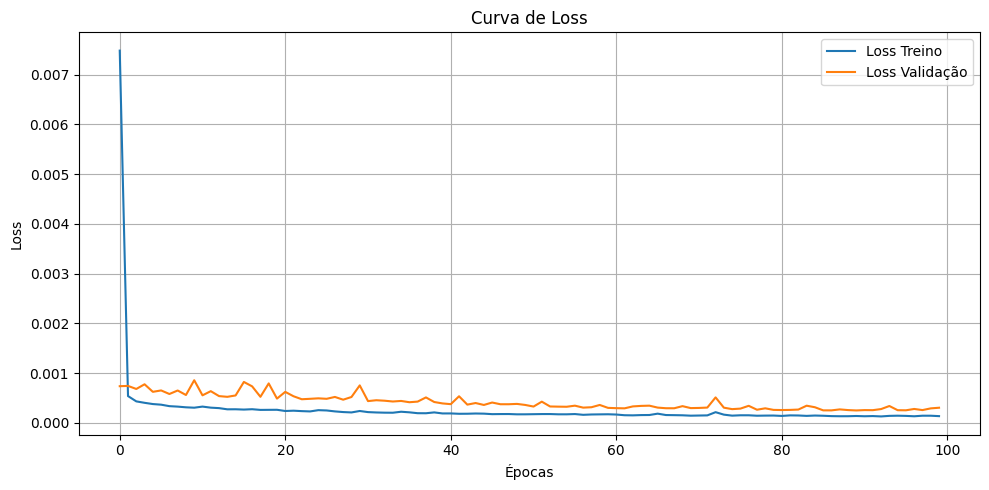

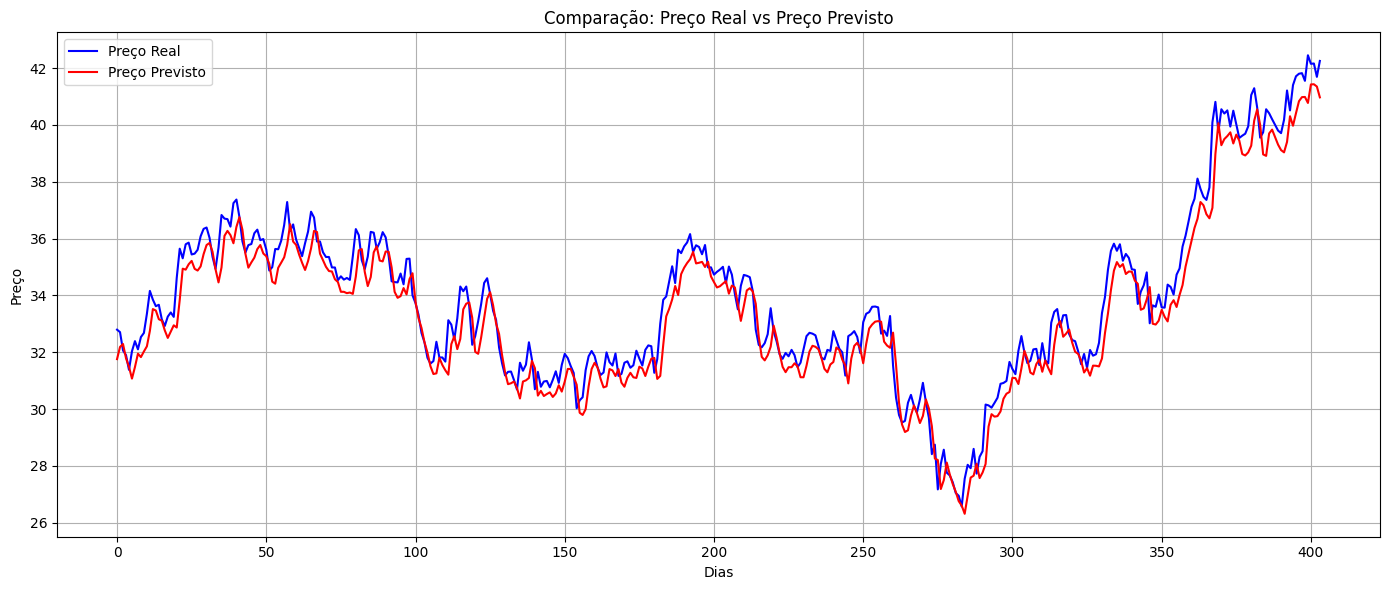

In [24]:
# MLflow: tracking local e experimento nomeado
# mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Previsao_Stock_LSTM")
mlflow.keras.autolog()

with mlflow.start_run(run_name="Treinamento_LSTM"):
    # early_stop = EarlyStopping(monitor='val_loss', patience=10)

    modelo = Sequential()
    modelo.add(LSTM(50, input_shape=(previsao_em_dias, 1)))
    modelo.add(Dense(1))
    modelo.compile(loss='mean_squared_error', optimizer='adam')

    # 👇 Aqui capturamos o histórico para gerar o gráfico depois
    history = modelo.fit(
        x_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        # callbacks=[early_stop],
        verbose=1
    )

    # Predição
    y_pred_scaled = modelo.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

    # RMSE
    rmse = sqrt(mean_squared_error(y_real, y_pred))
    mlflow.log_metric("rmse_real", rmse)

    # Salvar modelo local
    modelo.save(model_path)
    print("Modelo salvo com sucesso!")

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10,5))
    plt.plot(loss, label='Loss Treino')
    plt.plot(val_loss, label='Loss Validação')
    plt.title('Curva de Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Salvar gráfico e logar como artefato
    loss_plot_path = "models_saved/loss_plot.png"
    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # 👇 Comparando real vs previsto (gráfico extra opcional)
    plt.figure(figsize=(14,6))
    plt.plot(y_real, label="Preço Real", color='blue')
    plt.plot(y_pred, label="Preço Previsto", color='red')
    plt.title("Comparação: Preço Real vs Preço Previsto")
    plt.xlabel("Dias")
    plt.ylabel("Preço")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    comparativo_path = "models_saved/comparacao_plot.png"
    plt.savefig(comparativo_path)
    mlflow.log_artifact(comparativo_path)

    print(f"Preço médio real: {y_real.mean():.2f}")
    erro_percentual = (rmse / y_real.mean()) * 100
    print(f"Erro percentual médio aproximado: {erro_percentual:.2f}%")

In [26]:
# 4. Salvar localmente como .h5
modelo.save("modelo_lstm.h5")